#### Loading Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from itertools import product

#Tests for sample comparison
from scipy.stats import spearmanr
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.stats import mannwhitneyu

#ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.tsa.seasonal import seasonal_decompose

#Prophet
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#Libraries for tuning NHITS and envieroment setup
import logging
from ray import tune
from IPython.display import display
#NHITS
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MAE,RMSE,MQLoss

from utilsforecast.plotting import plot_series
from utilsforecast.losses import mse, mae, rmse
from utilsforecast.evaluation import evaluate

#Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
from sklearn.preprocessing import LabelEncoder

#LightGBM
import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping, log_evaluation


/home/armandoim/miniconda3/envs/myenv/lib/python3.12/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


#### Loading Data

In [3]:
train_set = pd.read_csv(r"/mnt/c/Users/aimeraj/Desktop/data/train.csv")
stores_set = pd.read_csv(r"/mnt/c/Users/aimeraj/Desktop/data/stores.csv")
oil_set = pd.read_csv(r"/mnt/c/Users/aimeraj/Desktop/data/oil.csv")
holiday_set = pd.read_csv(r"/mnt/c/Users/aimeraj/Desktop/data/holidays_events.csv")
transactions_set =pd.read_csv(r"/mnt/c/Users/aimeraj/Desktop/data/transactions.csv")

#### Display Options

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
#αν θελω reset
#pd.reset_option('display.max_columns')

#### Data Preparation

In [5]:
#ελεγχος για διπλοτυπα
print(train_set.duplicated().sum(),
      stores_set.duplicated().sum(),
      oil_set.duplicated().sum(),
      holiday_set.duplicated().sum(),
      transactions_set.duplicated().sum()
      )

0 0 0 0 0


In [6]:
train_set.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [7]:
stores_set.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [8]:
oil_set.head()

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

In [9]:
holiday_set.head()

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [10]:
holiday_set.locale.unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [11]:
transactions_set.head()

date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922

In [12]:
#Merges
df = pd.merge(train_set,stores_set,on='store_nbr',how='left')
df = pd.merge(df,oil_set,on ='date',how='left')
df = pd.merge(df,transactions_set,on=['date','store_nbr'],how='left')

In [13]:
df.head()

id        date  store_nbr      family  sales  onpromotion   city  \
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0  Quito   
1   1  2013-01-01          1   BABY CARE    0.0            0  Quito   
2   2  2013-01-01          1      BEAUTY    0.0            0  Quito   
3   3  2013-01-01          1   BEVERAGES    0.0            0  Quito   
4   4  2013-01-01          1       BOOKS    0.0            0  Quito   

       state type  cluster  dcoilwtico  transactions  
0  Pichincha    D       13         NaN           NaN  
1  Pichincha    D       13         NaN           NaN  
2  Pichincha    D       13         NaN           NaN  
3  Pichincha    D       13         NaN           NaN  
4  Pichincha    D       13         NaN           NaN

In [14]:
print(
    f"The dataset contains {df.shape[0]} samples and "
    f"{df.shape[1]} features"
)

The dataset contains 3000888 samples and 12 features


In [15]:
#Κοιταω για Nas
df.isna().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type                 0
cluster              0
dcoilwtico      928422
transactions    245784
dtype: int64

In [16]:
sales_zero = df[df['sales'] == 0]

In [17]:
sales_zero.isna().sum() # 291028 - 245869 = 45159

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type                 0
cluster              0
dcoilwtico      291028
transactions    242536
dtype: int64

In [18]:
df.loc[df['sales']==0,'transactions']=0
del sales_zero
df['transactions'] = df.groupby('store_nbr')['transactions'].ffill()

In [19]:
#Απο αυτο βλεπουμε οτι δεν εχουμε την τιμη του πετρελαιου για ολες τις ημερομινιες
print(len(train_set['date'].unique()),len(oil_set['date'].unique()))

1684 1218


In [20]:
df['date']= pd.to_datetime(df['date'])
df['day']= df['date'].dt.day_name()
working_days = df[df['date'].dt.dayofweek < 5]

In [21]:
print(df.loc[df['day'] == 'Saturday', 'dcoilwtico'].isna().sum() +
      df.loc[df['day'] == 'Sunday', 'dcoilwtico'].isna().sum() 
      )

857142


In [22]:
#Βρισκω το Σ/Κ με τιμες Na στο πετρελαιο
weekend_mask = df['day'].isin(['Saturday', 'Sunday']) & df['dcoilwtico'].isna()
df['price_filled'] = df['dcoilwtico']
df['price_filled'] = df['price_filled'].where(df['day'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']))
df['price_filled'] = df['price_filled'].ffill()
df.loc[weekend_mask, 'dcoilwtico'] = df.loc[weekend_mask, 'price_filled']
df.drop(columns=['price_filled'], inplace=True)

In [23]:
df['dcoilwtico'] = df['dcoilwtico'].interpolate(method='linear')
df['dcoilwtico'] = df['dcoilwtico'].bfill()
df['transactions'] = df['transactions'].fillna(0)

In [24]:
#Για τις υπολοιπες τιμες του πετρελαιου που δεν εχουμε κανουμε imputation
#df['dcoilwtico'] = df['dcoilwtico'].ffill()

In [25]:
holiday_set.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   type          object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  transactions  float64       
 12  day           object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(5)
memory usage: 297.6+ MB


In [27]:
transactions_set.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [28]:
df.isna().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
type            0
cluster         0
dcoilwtico      0
transactions    0
day             0
dtype: int64

In [29]:
df.isna().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
type            0
cluster         0
dcoilwtico      0
transactions    0
day             0
dtype: int64

In [30]:
df.head()

id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4   4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type  cluster  dcoilwtico  transactions      day  
0    D       13       93.14           0.0  Tuesday  
1    D       13       93.14           0.0  Tuesday  
2    D       13       93.14           0.0  Tuesday  
3    D       13       93.14           0.0  Tuesday  
4    D       13       93.14           0.0  Tuesday

#### Exploratory Data Analysis

In [31]:
df.head()

id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4   4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type  cluster  dcoilwtico  transactions      day  
0    D       13       93.14           0.0  Tuesday  
1    D       13       93.14           0.0  Tuesday  
2    D       13       93.14           0.0  Tuesday  
3    D       13       93.14           0.0  Tuesday  
4    D       13       93.14           0.0  Tuesday

In [32]:
print(
    f"The dataset contains {df.shape[0]} samples and "
    f"{df.shape[1]} features"
)

The dataset contains 3000888 samples and 13 features


In [33]:
len(df['store_nbr'].unique())

54

In [34]:
df['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [35]:
len(df['family'].unique())

33

In [36]:
df['city'].unique()

array(['Quito', 'Cayambe', 'Latacunga', 'Riobamba', 'Ibarra',
       'Santo Domingo', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil',
       'Salinas', 'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad',
       'Cuenca', 'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [37]:
len(df['city'].unique())

22

In [38]:
df['state'].unique()

array(['Pichincha', 'Cotopaxi', 'Chimborazo', 'Imbabura',
       'Santo Domingo de los Tsachilas', 'Bolivar', 'Pastaza',
       'Tungurahua', 'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja',
       'El Oro', 'Esmeraldas', 'Manabi'], dtype=object)

In [39]:
len(df['state'].unique())

16

In [40]:
df['type'].unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

In [41]:
df['cluster'].unique()

array([13, 15,  6,  7,  3, 12, 16,  9,  1, 10,  8,  2,  4,  5, 11, 14, 17])

In [42]:
df['day'].unique()

array(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday'], dtype=object)

In [43]:
df[['sales','onpromotion','transactions','dcoilwtico']].describe()

sales   onpromotion  transactions    dcoilwtico
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   3.577757e+02  2.602770e+00  1.196714e+03  6.791966e+01
std    1.101998e+03  1.221888e+01  1.148411e+03  2.567090e+01
min    0.000000e+00  0.000000e+00  0.000000e+00  2.619000e+01
25%    0.000000e+00  0.000000e+00  0.000000e+00  4.637750e+01
50%    1.100000e+01  0.000000e+00  1.113000e+03  5.341000e+01
75%    1.958473e+02  0.000000e+00  1.749000e+03  9.572000e+01
max    1.247170e+05  7.410000e+02  8.359000e+03  1.106200e+02

In [44]:
#Εδω δημιουργω ενα γραφημα για τα sales σε βαθος χρονου
#Για να γινει αυτο θα πρεπει να αθροισω τα sales καθε μερας καθως το υπαρχον dataset εχει 
#sales για ολες τις ημερες 
daily_sales = df[['date','sales']].copy()
daily_sales = daily_sales.groupby('date').sum().reset_index()


In [45]:
px.line(daily_sales,x='date',y='sales',title="Daily Sales")

In [46]:
#Εδω ενονω τις τιμες του πετρελαιου με τα daily sales για να κανω correlation test
daily_oil = df[['date', 'dcoilwtico']].dropna().drop_duplicates(subset='date')
daily_df = pd.merge(daily_sales,daily_oil,on='date',how='left')
daily_df.head()

date          sales  dcoilwtico
0 2013-01-01    2511.618999       93.14
1 2013-01-02  496092.417944       93.14
2 2013-01-03  361461.231124       92.97
3 2013-01-04  354459.677093       93.12
4 2013-01-05  477350.121229       93.12

In [47]:
moving_average = daily_df['sales'].rolling(
    window = len(daily_df['sales']),
    center = True,
    min_periods = len(daily_df['sales'])//2,
).mean()

daily_df['moving_average'] = moving_average

In [48]:
fig1 = px.scatter(daily_df, x='date', y='sales')
fig2 = px.line(daily_df, x='date', y='moving_average', color_discrete_sequence=['red'])
fig3 = go.Figure(data=fig1.data + fig2.data)
fig3 = fig3.update_layout(xaxis_title="Sales", yaxis_title="Date", title = 'Moving Average Over Time')
fig3.show()

In [49]:
df['year'] = df['date'].dt.year
avg_sales_year_family = df.groupby(['year', 'family'])['sales'].mean().reset_index()

In [50]:

fig = px.line(
    avg_sales_year_family,
    x='year',
    y='sales',
    color='family',
    facet_col='family',
    facet_col_wrap= 4,
    markers=True,
    title='Average Yearly Sales per Product Family'
)
fig.update_yaxes(matches=None)
fig.update_layout(height=2000,showlegend=False)

# fig.update_layout(
#     xaxis_title='Year',
#     yaxis_title='Average Sales',
#     legend_title='Family',
#     width=1000,
#     height=600
# )

fig.show()


In [51]:
df['month'] = df['date'].dt.month
df['month_name'] = df['date'].dt.strftime('%B')
avg_sales_by_month = df.groupby(['month', 'month_name', 'family'])['sales'].mean().reset_index()

avg_sales_by_month = avg_sales_by_month.sort_values('month')

In [52]:
fig = px.line(
    avg_sales_by_month,
    x='month_name',
    y='sales',
    color='family',
    facet_col='family',
    facet_col_spacing=0.1,
    facet_col_wrap=4,
    markers=True,
    category_orders={"month_name": [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]},
    title='Average Sales by Calendar Month per Product Family'
)
fig.update_yaxes(matches=None)
fig.update_layout(height=2000,showlegend=False)

# fig.update_layout(
#     xaxis_title='Month',
#     yaxis_title='Average Sales',
#     legend_title='Family',
#     width=1000,
#     height=600
# )

fig.show()


In [53]:
df['day_nbr'] = df['date'].dt.weekday
avg_sales_by_weekday = df.groupby(['day_nbr', 'day', 'family'])['sales'].mean().reset_index()

In [54]:
avg_sales_by_weekday = avg_sales_by_weekday.sort_values('day_nbr')
fig = px.line(
    avg_sales_by_weekday,
    x='day',
    y='sales',
    color='family',
    facet_col='family',
    facet_col_wrap=4,
    markers=True,
    category_orders={"day": [
        "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
    ]},
    title='Average Sales by Day of Week per Product Family'
)

fig.update_yaxes(matches=None)
fig.update_layout(height=2000,showlegend=False)

# fig.update_layout(
#     xaxis_title='Day of Week',
#     yaxis_title='Average Sales',
#     legend_title='Family',
#     width=1000,
#     height=600
# )

fig.show()


In [55]:
t = df.groupby("family")['sales'].mean().sort_values(ascending=False).reset_index()
px.bar(t,y='family',x='sales',color='family',title='Average sales per product family')

In [56]:
t = df.groupby("city")['sales'].mean().sort_values(ascending=False).reset_index()
px.bar(t,y='city',x='sales',color='city',title='Average sales per City')

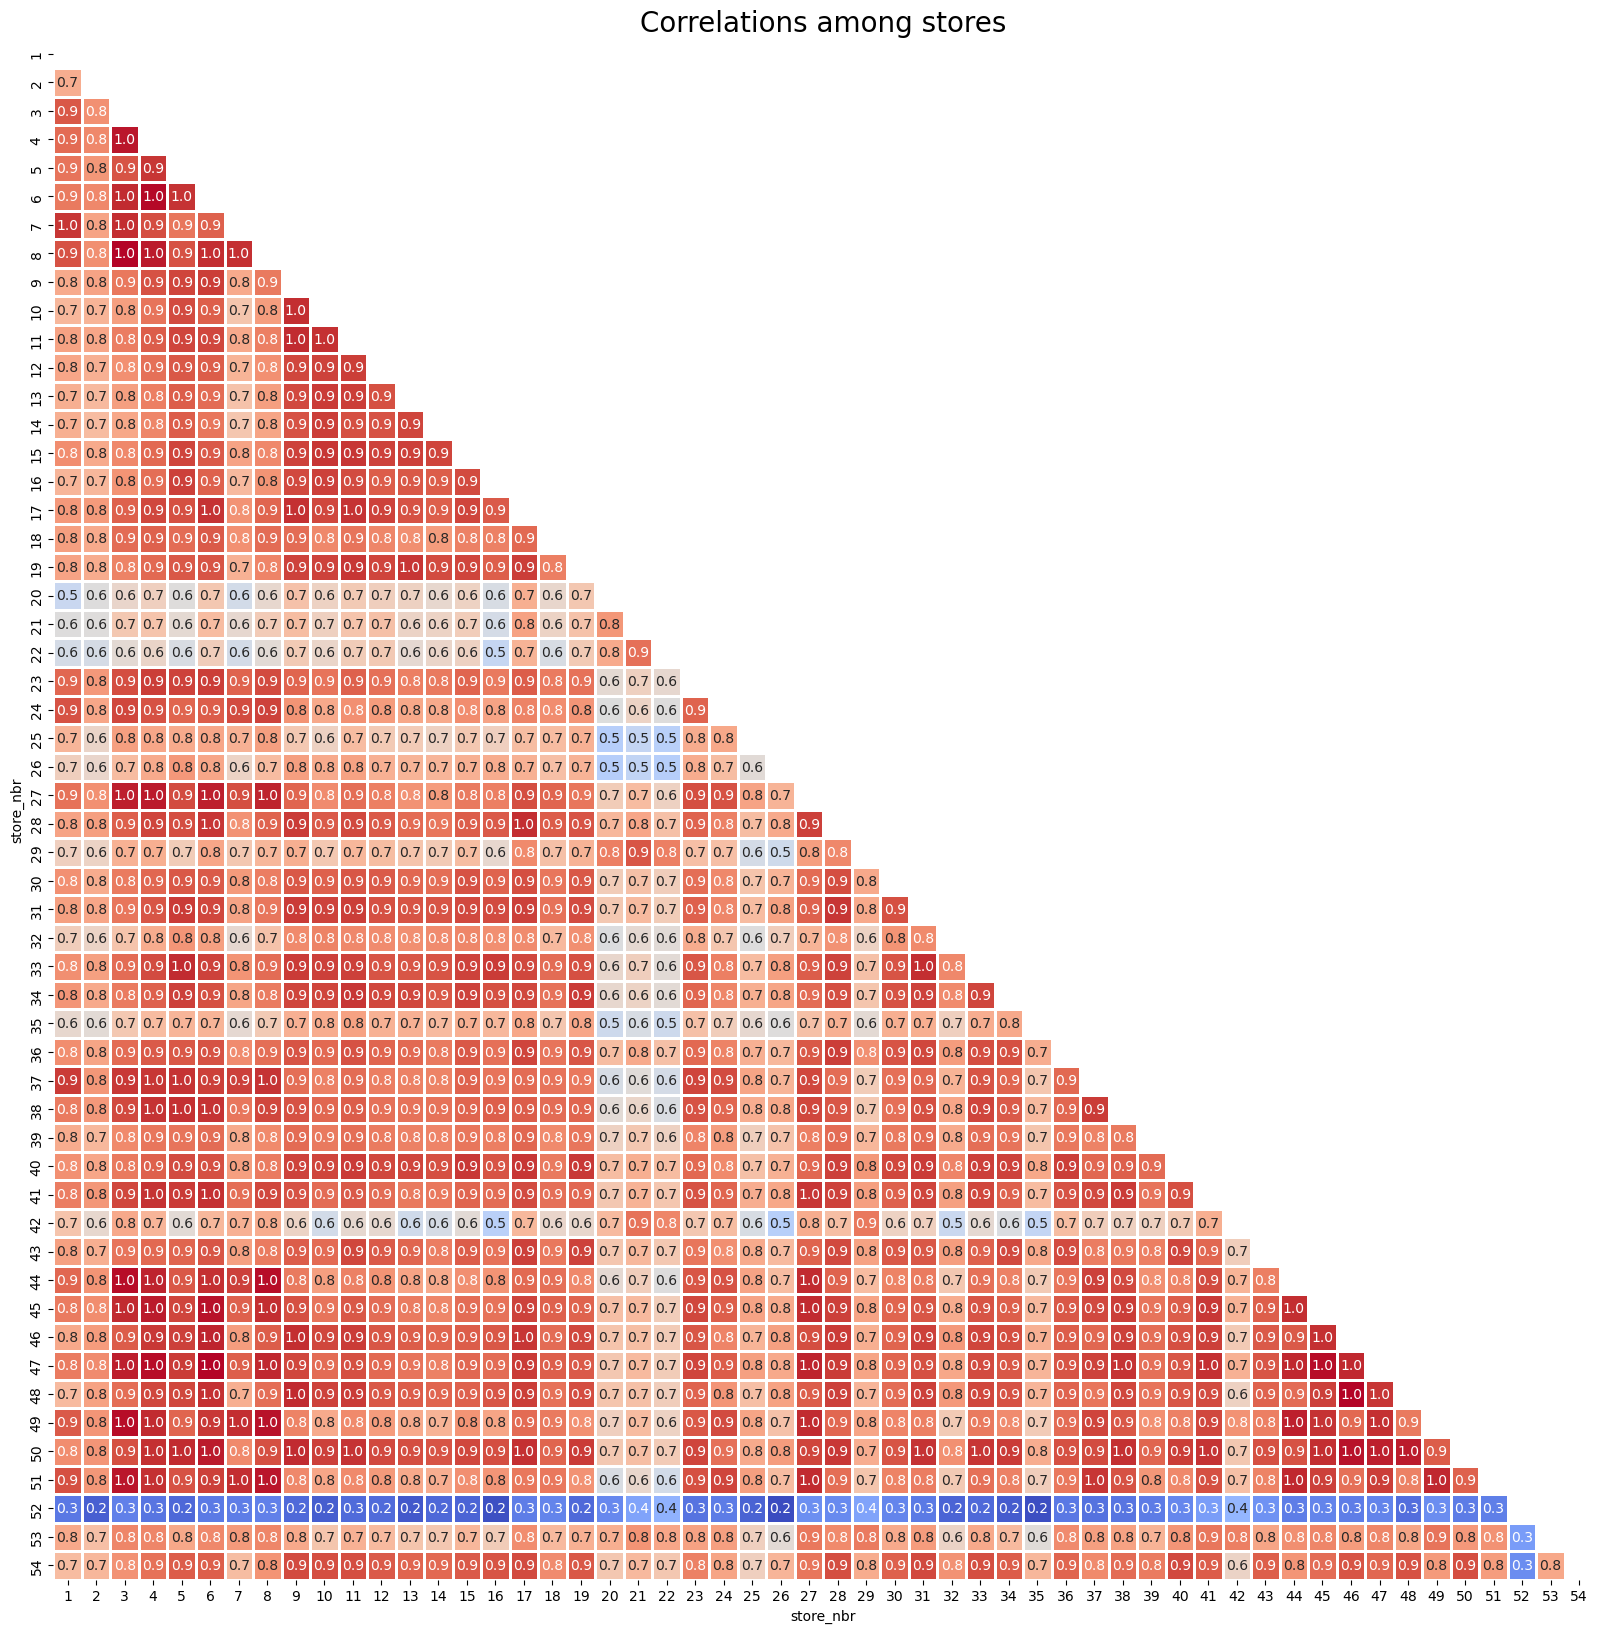

In [57]:

temp = df[["store_nbr", "sales"]].copy()
temp["ind"] = 1
temp["ind"] = temp.groupby("store_nbr")["ind"].cumsum().values
pivot_sales = pd.pivot(temp, index="ind", columns="store_nbr", values="sales")

corr_matrix = pivot_sales.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)
plt.title("Correlations among stores", fontsize=20)
plt.show()

#### Oil Price - Impact on Sales

In [58]:
#Αυτο εχει και αλλη δουλεια
px.line(daily_oil,x='date',y='dcoilwtico')

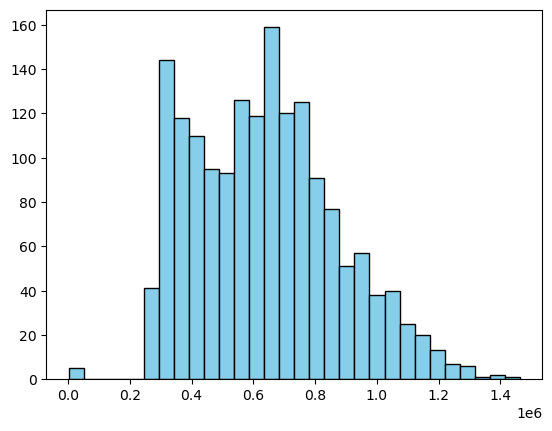

In [59]:
plt.hist(daily_df['sales'],bins=30, color='skyblue', edgecolor='black');

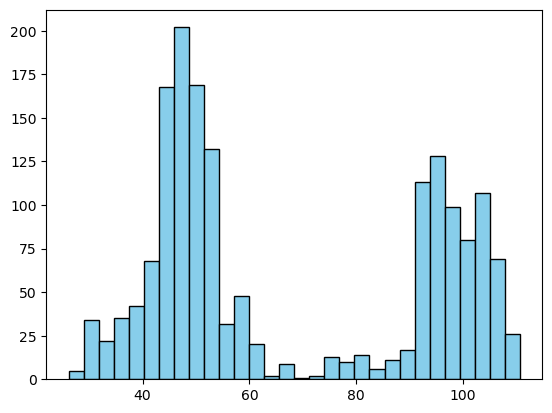

In [60]:
plt.hist(daily_df['dcoilwtico'],bins=30, color='skyblue', edgecolor='black');

In [61]:
corr, p_value = spearmanr(daily_df['sales'], daily_df['dcoilwtico'])

print(f"Spearman correlation: {corr}")
print(f"P-value: {p_value}")

Spearman correlation: -0.6082715617552258
P-value: 5.664189454391659e-171


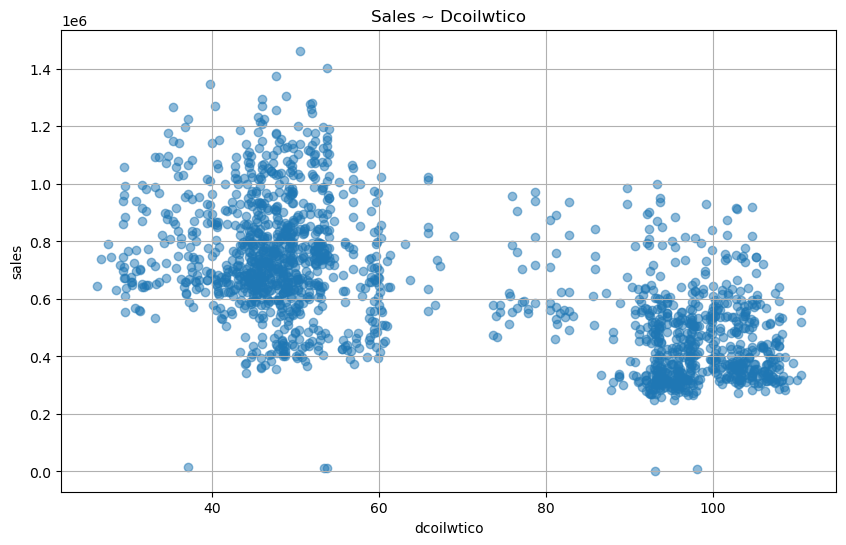

In [62]:
plt.figure(figsize=(10, 6))
plt.scatter(daily_df['dcoilwtico'], daily_df['sales'], alpha=0.5)
plt.title('Sales ~ Dcoilwtico')
plt.xlabel('dcoilwtico')
plt.ylabel('sales')
plt.grid(True)
plt.show()


#### OnPromotion - Impact on Sales

In [63]:
corr, p_value = spearmanr(df['sales'], df['onpromotion'])

print(f"Spearman correlation: {corr}")
print(f"P-value: {p_value}")


Spearman correlation: 0.5380218163563323
P-value: 0.0


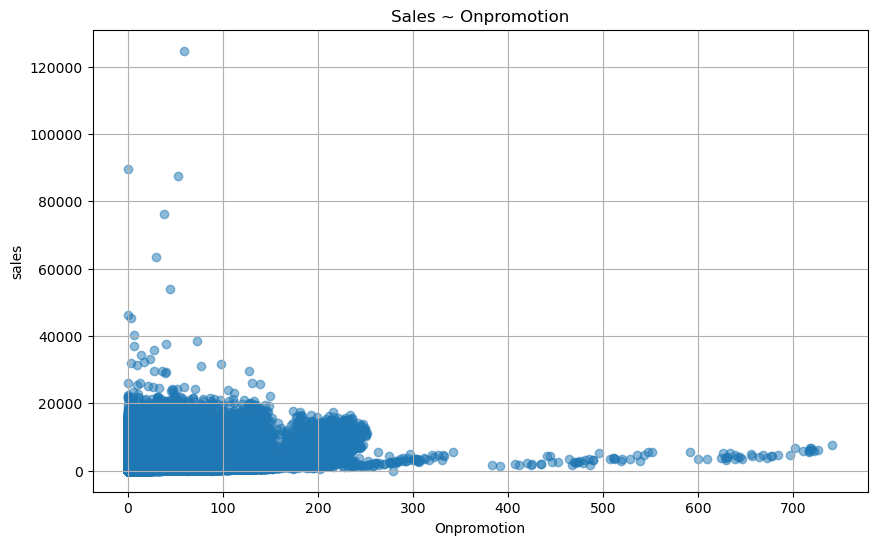

In [64]:
plt.figure(figsize=(10, 6))
plt.scatter(df['onpromotion'],df['sales'], alpha=0.5)
plt.title('Sales ~ Onpromotion')
plt.xlabel('Onpromotion')
plt.ylabel('sales')
plt.grid(True)
plt.show()

#### Earthquake - Impact on Sales

In [65]:
daily_df["date"] = pd.to_datetime(daily_df["date"])
before = daily_df[(daily_df["date"] >= '2016-03-01') & (daily_df["date"] <= '2016-04-15')]
after = daily_df[(daily_df["date"] >= '2016-04-16') & (daily_df["date"] <= '2016-05-31')]

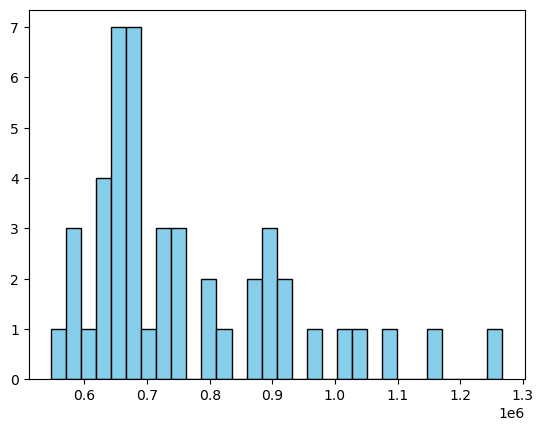

In [66]:
plt.hist(before['sales'], bins=30, color='skyblue', edgecolor='black');


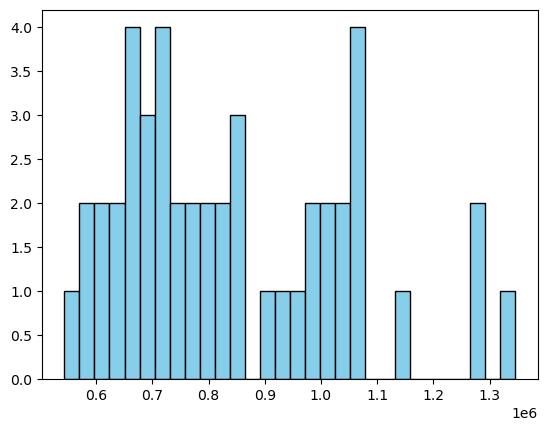

In [67]:
plt.hist(after['sales'], bins=30, color='skyblue', edgecolor='black');


In [68]:
stat, p_value = mannwhitneyu(before['sales'], after['sales'])

print(f"U statistic: {stat}")
print(f"P-value: {p_value}")

U statistic: 785.0
P-value: 0.03334269022409122


In [69]:
before[['sales']].describe()

sales
count  4.600000e+01
mean   7.631802e+05
std    1.625897e+05
min    5.467852e+05
25%    6.606319e+05
50%    6.925578e+05
75%    8.769561e+05
max    1.266908e+06

In [70]:
after[['sales']].describe()

sales
count  4.600000e+01
mean   8.427815e+05
std    2.017883e+05
min    5.433398e+05
25%    6.832532e+05
50%    7.954300e+05
75%    9.943918e+05
max    1.345921e+06

In [71]:
df[['sales']].describe()

sales
count  3.000888e+06
mean   3.577757e+02
std    1.101998e+03
min    0.000000e+00
25%    0.000000e+00
50%    1.100000e+01
75%    1.958473e+02
max    1.247170e+05

In [72]:
del avg_sales_by_month,avg_sales_by_weekday,avg_sales_year_family,moving_average,daily_df,daily_oil,daily_sales
del train_set,oil_set,transactions_set,stores_set,before,after,weekend_mask
del fig,fig1,fig2,fig3,working_days,

In [73]:
%who

ARIMA	 AutoLSTM	 AutoNHITS	 GridSearchCV	 LGBMRegressor	 LSTM	 LabelEncoder	 MAE	 MQLoss	 
NHITS	 NeuralForecast	 Prophet	 RMSE	 TimeSeriesSplit	 corr	 corr_matrix	 cross_validation	 df	 
display	 early_stopping	 evaluate	 go	 holiday_set	 lgb	 lilliefors	 log_evaluation	 logging	 
mae	 mannwhitneyu	 mask	 mean_squared_error	 mean_squared_log_error	 mse	 np	 p_value	 pd	 
performance_metrics	 pivot_sales	 plot_cross_validation_metric	 plot_series	 plt	 product	 px	 r2_score	 rmse	 
seasonal_decompose	 shapiro	 sns	 spearmanr	 stat	 stats	 t	 temp	 train_test_split	 
tune	 


In [74]:
holiday_set['date'] = pd.to_datetime(holiday_set['date'])
holiday_set[holiday_set['transferred']==True]

date     type    locale locale_name                    description  \
19  2012-10-09  Holiday  National     Ecuador     Independencia de Guayaquil   
72  2013-10-09  Holiday  National     Ecuador     Independencia de Guayaquil   
135 2014-10-09  Holiday  National     Ecuador     Independencia de Guayaquil   
255 2016-05-24  Holiday  National     Ecuador           Batalla de Pichincha   
266 2016-07-25  Holiday     Local   Guayaquil         Fundacion de Guayaquil   
268 2016-08-10  Holiday  National     Ecuador  Primer Grito de Independencia   
297 2017-01-01  Holiday  National     Ecuador             Primer dia del ano   
303 2017-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
312 2017-05-24  Holiday  National     Ecuador           Batalla de Pichincha   
324 2017-08-10  Holiday  National     Ecuador  Primer Grito de Independencia   
328 2017-09-28  Holiday     Local      Ibarra            Fundacion de Ibarra   
340 2017-12-06  Holiday     Local       Quito             Fundacion de Quito   

     transferred  
19          True  
72          True  
135         True  
255         True  
266         True  
268         True  
297         True  
303         True  
312         True  
324         True  
328         True  
340         True

In [75]:
#Το προβλημα με τα transfers
temp1 = holiday_set[(holiday_set['type']=='Holiday')& (holiday_set['transferred']==True)].drop('transferred',axis=1).reset_index(drop=True)
temp2 = holiday_set[(holiday_set['type']=='Transfer')].drop('transferred',axis=1).reset_index(drop=True)
temp = pd.concat([temp1,temp2],axis=1)
temp = temp.iloc[:,[5,1,2,3,4,]]
holiday_set = holiday_set[(holiday_set['type']!='Transfer')& (holiday_set['transferred']==False)].drop('transferred',axis=1)
holiday_set = pd.concat([holiday_set, temp]).reset_index(drop=True)
del temp,temp1,temp2

In [76]:
holiday_set['type']= np.where(holiday_set['type']=='Additional','Holiday',holiday_set['type'])
holiday_set['type']= np.where(holiday_set['type']=='Bridge','Holiday',holiday_set['type'])

In [77]:
work_days_left = holiday_set[holiday_set.type=='Work Day']
holiday_set = holiday_set[holiday_set.type!='Work Day']

In [78]:
#Κραταω αυτο για το Prophet μετα
holidays_for_prophet = holiday_set.drop(['type','locale','locale_name'],axis=1)

In [79]:
events = holiday_set[holiday_set.type=='Event'].drop(['type','locale','locale_name'],axis=1)
events= events.rename({"description":"event"},axis=1)
holiday_set = holiday_set[holiday_set.type!='Event'].drop("type",axis=1)

In [80]:
regional = holiday_set[holiday_set['locale']=='Regional'].rename({"locale_name":"state","description":"holiday_regional"},axis=1).drop("locale",axis=1).drop_duplicates()
national = holiday_set[holiday_set['locale']=='National'].rename({"description":"holiday_national"},axis=1).drop(["locale","locale_name"],axis=1).drop_duplicates()
local = holiday_set[holiday_set['locale']=='Local'].rename({"locale_name":"city","description":"holiday_local"},axis=1).drop("locale",axis=1).drop_duplicates()

In [81]:
national['date'] = pd.to_datetime(national['date'])
regional['date'] = pd.to_datetime(regional['date'])
df = pd.merge(df,national,how='left',on='date')
df = pd.merge(df,regional,how='left',on=['date',"state"])
df = pd.merge(df,local,how='left',on=['date',"city"])
df = pd.merge(df,events,on=['date'],how='left')
del national,regional,local

In [82]:
df["holiday_national_binary"] = np.where(df["holiday_national"].notnull(),1,0)
df["holiday_regional_binary"] = np.where(df["holiday_regional"].notnull(),1,0)
df["holiday_local_binary"] = np.where(df["holiday_local"].notnull(),1,0)

In [83]:
encoded_events= pd.get_dummies(events,"event",dtype=int)
encoded_events.columns=encoded_events.columns.str.replace(" ","_")
encoded_events.columns=encoded_events.columns.str.replace(":","_")
encoded_events.columns=encoded_events.columns.str.replace("+","_")
encoded_events.columns=encoded_events.columns.str.replace("-","_")
df = pd.merge(df,encoded_events,how='left',on='date')
del encoded_events,events

In [84]:
df['event'] = df['event'].fillna('no_event')
df['holiday_national'] = df['holiday_national'].fillna('no_holiday')
df['holiday_regional'] = df['holiday_regional'].fillna('no_holiday')
df['holiday_local'] = df['holiday_local'].fillna('no_holiday')
event_cols = [col for col in df.columns if col.startswith('event')]
event_cols.remove('event')
df[event_cols] = df[event_cols].fillna(0).astype(int)

In [85]:
df.shape

(3008280, 67)

In [86]:
def AB_Test(d,group,target):
    groupA = d[d[group] == 1][target]
    groupB = d[d[group] == 0][target]
    if(len(groupA)<50):
        t1 = shapiro(groupA)[1] < 0.05
    else:
        t1 = lilliefors(groupA)[1] < 0.05
    
    if(len(groupB)<50):
        t2 = shapiro(groupB)[1] < 0.05
    else:
        t2 = lilliefors(groupB)[1] < 0.05
    
    if (t1 == False) & (t1 == False):
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        
        if leveneTest == False:
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]

        else:
            ttest = stats.wilcoxon(groupA, groupB, equal_var=False)[1]

    else:
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 

    temp = pd.DataFrame({
        "variable":[group],
        "p-value":[ttest]
    })
    return temp

results = []

for i in ['holiday_national_binary','holiday_regional_binary','holiday_local_binary']:
    results.append(AB_Test(d=df[df['sales'].notnull()],group=i,target='sales'))

results = pd.concat(results)

In [87]:
results

variable       p-value
0  holiday_national_binary  6.587028e-03
0  holiday_regional_binary  3.379323e-04
0     holiday_local_binary  1.844151e-11

In [88]:
# results=[]
# for i in event_cols:
#     results.append(AB_Test(d=df[df['sales'].notnull()],group=i,target='sales'))
# results = pd.concat(results)
# results

In [89]:
results.loc[results['p-value']>0.05,]
del results

In [90]:
df['unique_id'] = df['store_nbr'].astype(str) + '_' + df['family']

In [91]:
#Zero forecasting
zero_sales = df[['unique_id','sales']].copy()
zero_sales=zero_sales.groupby(['unique_id']).sum().reset_index()
zero_sales=zero_sales[zero_sales['sales']==0]

In [92]:
zero_sales

unique_id  sales
4               10_BOOKS    0.0
37              11_BOOKS    0.0
70              12_BOOKS    0.0
100         13_BABY CARE    0.0
103             13_BOOKS    0.0
136             14_BOOKS    0.0
152   14_LAWN AND GARDEN    0.0
169             15_BOOKS    0.0
202             16_BOOKS    0.0
217        16_LADIESWEAR    0.0
235             17_BOOKS    0.0
268             18_BOOKS    0.0
301             19_BOOKS    0.0
331          1_BABY CARE    0.0
367             20_BOOKS    0.0
400             21_BOOKS    0.0
433             22_BOOKS    0.0
463         23_BABY CARE    0.0
547        25_LADIESWEAR    0.0
631             28_BOOKS    0.0
646        28_LADIESWEAR    0.0
664             29_BOOKS    0.0
679        29_LADIESWEAR    0.0
730             30_BOOKS    0.0
746   30_LAWN AND GARDEN    0.0
763             31_BOOKS    0.0
796             32_BOOKS    0.0
811        32_LADIESWEAR    0.0
829             33_BOOKS    0.0
844        33_LADIESWEAR    0.0
862             34_BOOKS    0.0
895             35_BOOKS    0.0
910        35_LADIESWEAR    0.0
928             36_BOOKS    0.0
1027            39_BOOKS    0.0
1093            40_BOOKS    0.0
1108       40_LADIESWEAR    0.0
1192            43_BOOKS    0.0
1207       43_LADIESWEAR    0.0
1222        44_BABY CARE    0.0
1255        45_BABY CARE    0.0
1288        46_BABY CARE    0.0
1321        47_BABY CARE    0.0
1354        48_BABY CARE    0.0
1387        49_BABY CARE    0.0
1453        50_BABY CARE    0.0
1486        51_BABY CARE    0.0
1519        52_BABY CARE    0.0
1522            52_BOOKS    0.0
1588            54_BOOKS    0.0
1603       54_LADIESWEAR    0.0
1604  54_LAWN AND GARDEN    0.0
1753             9_BOOKS    0.0

In [93]:
zero_sales.shape # βαση αυτου υπαρχουν 53 combos που εχουν 0 πωλησεις

(53, 2)

#### Models

In [94]:
#Prophet

In [95]:
# agg_df = df.groupby(['date','unique_id']).agg({'sales':'sum'}).reset_index().sort_values(['unique_id','date'])
# total_sales_df = agg_df.pivot(index='date',columns='unique_id', values='sales')

In [96]:
# changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
# print(changepoint_prior_scale_range)

In [97]:
# seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
# holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

In [98]:
# dicts = {}

# for feature in total_sales_df.columns[:1]:
  
#     category_df = total_sales_df[feature].copy().reset_index()
#     category_df.columns = ["ds", "y"]

#     category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
#     category_df["ds"] = pd.to_datetime(category_df["ds"])
    
#     param_grid = {  
#         "changepoint_prior_scale": changepoint_prior_scale_range,
#         "seasonality_prior_scale": seasonality_prior_scale_range }

#     # Generate all combinations of parameters
#     all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
#     maes = [] 

#     # Use cross validation to evaluate all parameters
#     for params in all_params:
#         m = Prophet(**params).fit(category_df)  # Fit model with given params
#         df_cv = cross_validation(m, initial="365 days", period="30 days", horizon = "30 days")
#         df_p = performance_metrics(df_cv, rolling_window=1)
#         print(df_p)
#         maes.append(df_p["mae"].values[0])

#     # Find the best parameters
#     tuning_results = pd.DataFrame(all_params)
#     tuning_results["mae"] = maes
    
#     print(feature)
#     print(tuning_results.head())

#     params_dict = dict(tuning_results.sort_values("mae").reset_index(drop=True).iloc[0])
#     params_dict["column"] = feature 
    
#     dicts[feature] = params_dict

In [99]:
# prediction_days = 30
# forecast_start_date = '2017-07-15'

In [100]:
# holidays_for_prophet=holidays_for_prophet.rename({'date':'ds','description':'holiday'},axis=1)
# holidays_for_prophet['ds'] = pd.to_datetime(holidays_for_prophet['ds'])

In [101]:
# forecasted_dfs = []

# for feature in total_sales_df.columns[:1]:

#     df_copy = total_sales_df[feature].copy().reset_index()
#     df_copy.columns = ['ds','y']
#     df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

#     df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
#     df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
#     #finding the right params_dict for this unique_id
#     params_dict = dicts[feature]
    
#     #model
#     m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
#                 seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
#                 seasonality_mode = 'multiplicative',
#                 holidays=holidays_for_prophet
#                 )
    
#     m.fit(df_copy_)

#     future = m.make_future_dataframe(periods=prediction_days)
#     fcst_prophet_train = m.predict(future)
    
#     filter = fcst_prophet_train['ds']>=forecast_start_date 
#     predicted_df = fcst_prophet_train[filter][['ds','yhat']]
#     predicted_df = predicted_df.merge(df_copy)

#     print(feature,mean_squared_log_error(predicted_df['y'],predicted_df['yhat']))

In [102]:
# forecast_start_date= max(total_sales_df.index)

In [103]:
# forecasted_dfs = []

# for feature in total_sales_df.columns[:1]:
    
#     #formatting
#     df_copy = total_sales_df[feature].copy().reset_index()
#     df_copy.columns = ['ds','y']
#     df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

#     df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
#     df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
#     #finding the right params_dict for this category
#     params_dict = dicts[feature]
    
#     #model
#     m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
#                 seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
#                 seasonality_mode = 'multiplicative',
#                 holidays=holidays_for_prophet
#                 )
    
#     m.fit(df_copy_)

#     future = m.make_future_dataframe(periods=prediction_days)
#     fcst_prophet_train = m.predict(future)
    
#     fig1 = m.plot(fcst_prophet_train)
#     fig2 = m.plot_components(fcst_prophet_train)

#     forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]
    
#     #forecasted_dfs.append(forecasted_df) #οταν αλλαξω το ποσα combos θα δω τοτε θα βαλω αυτο

In [104]:
#END OF PROPHET

In [105]:
original = df.copy()

In [106]:
df.head()

id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4   4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type  cluster  dcoilwtico  transactions      day  year  month month_name  \
0    D       13       93.14           0.0  Tuesday  2013      1    January   
1    D       13       93.14           0.0  Tuesday  2013      1    January   
2    D       13       93.14           0.0  Tuesday  2013      1    January   
3    D       13       93.14           0.0  Tuesday  2013      1    January   
4    D       13       93.14           0.0  Tuesday  2013      1    January   

   day_nbr    holiday_national holiday_regional holiday_local     event  \
0        1  Primer dia del ano       no_holiday    no_holiday  no_event   
1        1  Primer dia del ano       no_holiday    no_holiday  no_event   
2        1  Primer dia del ano       no_holiday    no_holiday  no_event   
3        1  Primer dia del ano       no_holiday    no_holiday  no_event   
4        1  Primer dia del ano       no_holiday    no_holiday  no_event   

   holiday_national_binary  holiday_regional_binary  holiday_local_binary  \
0                        1                        0                     0   
1                        1                        0                     0   
2                        1                        0                     0   
3                        1                        0                     0   
4                        1                        0                     0   

   event_Black_Friday  event_Cyber_Monday  event_Dia_de_la_Madre  \
0                   0                   0                      0   
1                   0                   0                      0   
2                   0                   0                      0   
3                   0                   0                      0   
4                   0                   0                      0   

   event_Inauguracion_Mundial_de_futbol_Brasil  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

   event_Mundial_de_futbol_Brasil__Cuartos_de_Final  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   event_Mundial_de_futbol_Brasil__Ecuador_Francia  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   event_Mundial_de_futbol_Brasil__Ecuador_Honduras  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   event_Mundial_de_futbol_Brasil__Ecuador_Suiza  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   event_Mundial_de_futbol_Brasil__Final  \
0                                      0   
1                                  

In [ ]:
#LightGBM

In [ ]:
agg_df = df.groupby(['date','unique_id']).agg({'sales':'sum'}).reset_index().sort_values(['unique_id','date'])
total_sales_df = agg_df.pivot(index='date',columns='unique_id', values='sales')

In [ ]:
forecast_start_date = '2017-07-15'

In [ ]:
import warnings
warnings.filterwarnings("once")

In [ ]:
#Tuning
dicts = {}
i = 0
for feature in total_sales_df.columns[:10]:
    selected_feature = str(feature)
    category_df = total_sales_df[feature].copy().reset_index()
    temp = df[df['unique_id'] == selected_feature].copy()
    category_df.columns = ["date", "sales"]

    temp = temp.drop(['id', 'store_nbr', 'family',
        'sales','city','state', 'type', 'cluster',
        'dcoilwtico', 'transactions','day','month_name',
        'holiday_national','holiday_regional',
        'holiday_local', 'event','unique_id'],axis=1)

    category_df["date"] = pd.to_datetime(category_df["date"])
    category_df= pd.merge(category_df,temp,on='date',how='left')
    category_df=category_df.drop_duplicates()
    category_df= category_df.drop_duplicates(subset=['date', 'sales'])
    category_df["lag1"] = category_df["sales"].shift(1)
    category_df["lag2"] = category_df["sales"].shift(2)
    category_df["lag3"] = category_df["sales"].shift(3)
    category_df["lag7"] = category_df["sales"].shift(7)
    category_df["lag14"] = category_df["sales"].shift(14)
    category_df["lag28"] = category_df["sales"].shift(28)
    category_df=category_df.dropna()

    y = category_df['sales']
    features= category_df.columns.tolist()[2:]
    X = category_df[features]

    param_grid = {
        'num_leaves': [15, 31],
        'learning_rate': [0.01,0.05, 0.1],
        'n_estimators': [100, 200]
    }

    lgb_reg = lgb.LGBMRegressor()

    tscv = TimeSeriesSplit(n_splits=3)
    grid = GridSearchCV(estimator=lgb_reg,
                        param_grid=param_grid,
                        cv=tscv,
                        scoring='neg_mean_absolute_error',
                        verbose=0)

    grid.fit(X, y)

    best_params = grid.best_params_
    best_score = -grid.best_score_

    best_params_with_score = best_params.copy()
    best_params_with_score["mae"] = best_score
    dicts[feature] = best_params_with_score
    print(f"✅-{i}")
    i += 1

In [ ]:
dicts

In [ ]:
results = []
i = 0
for feature in total_sales_df.columns[:10]:
    selected_feature = str(feature)
    category_df = total_sales_df[feature].copy().reset_index()
    temp = df[df['unique_id'] == selected_feature].copy()
    category_df.columns = ["date", "sales"]

    temp = temp.drop(['id', 'store_nbr', 'family',
        'sales','city','state', 'type', 'cluster',
        'dcoilwtico', 'transactions','day','month_name',
        'holiday_national','holiday_regional',
        'holiday_local', 'event','unique_id'],axis=1)
    temp = temp.drop(event_cols,axis=1)

    category_df["date"] = pd.to_datetime(category_df["date"])
    category_df= pd.merge(category_df,temp,on='date',how='left')
    category_df=category_df.drop_duplicates()
    category_df= category_df.drop_duplicates(subset=['date', 'sales'])
    category_df["lag1"] = category_df["sales"].shift(1)
    category_df["lag2"] = category_df["sales"].shift(2)
    category_df["lag3"] = category_df["sales"].shift(3)
    category_df["lag7"] = category_df["sales"].shift(7)
    category_df["lag14"] = category_df["sales"].shift(14)
    category_df["lag28"] = category_df["sales"].shift(28)
    category_df=category_df.dropna()

    y = category_df[['date', 'sales']]
    features= category_df.columns.tolist()[2:]
    # X = category_df[features]

    test_start='2017-07-15'
    X_train = category_df[category_df['date']<test_start].copy()
    y_train = y[y['date']<test_start].copy()

    X_val = category_df[category_df['date']>=test_start].copy()
    y_val = y[y['date']>=test_start].copy()

    y_train = y_train.drop(['date'],axis=1)
    y_val = y_val.drop(['date'],axis=1)

    X_train = X_train[features]
    X_val = X_val[features]
    #X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    # model = LGBMRegressor(
    #     objective='regression',
    #     n_estimators=1000,
    #     learning_rate=0.05,
    #     num_leaves=31
    # )
    model = LGBMRegressor(
        num_leaves=dicts[feature]['num_leaves'],
        learning_rate=dicts[feature]['learning_rate'],
        n_estimators=dicts[feature]['n_estimators'],
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ])


    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    #rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))
    m=category_df['sales'].mean()
    temp1 = pd.DataFrame({
                "unique_id":[selected_feature],
                "rmse":[rmse],
                "ymean": [m],
                })
    results.append(temp1)
    print(f"✅-{i}")
    i += 1
        # # Feature importance (split count)
        # importance_df = pd.DataFrame({
        #     'feature': model.feature_name_,
        #     'importance': model.feature_importances_
        # }).sort_values(by='importance', ascending=True)

        # # Horizontal bar plot
        # plt.figure(figsize=(10, 6))
        # plt.barh(importance_df['feature'], importance_df['importance'])
        # plt.xlabel('Split Count')
        # plt.title('Feature Importance')
        # plt.tight_layout()
        # plt.show()
results=pd.concat(results)

In [ ]:
results.describe()

In [ ]:
# df["lag1"] = df["sales"].shift(1)
# df["lag2"] = df["sales"].shift(2)
# df["lag3"] = df["sales"].shift(3)
# df["lag7"] = df["sales"].shift(7)
# df["lag14"] = df["sales"].shift(14)
# df["lag28"] = df["sales"].shift(28)

In [ ]:
df = original.copy()

In [ ]:
y = df[['date','sales']]
#y = df['sales']
features = ['family','onpromotion',
 'day_nbr',
 'store_nbr',
 'year',
 'month',
 'city',
 'state',
 'type',
 'cluster',
 'holiday_national_binary',
 'holiday_local_binary',
 'holiday_regional_binary',
]
X = df[features].copy()
cat_cols = ['family','city', 'state', 'type', 'cluster','store_nbr']
for col in cat_cols:
    X[col] = X[col].astype('category')


In [ ]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler


In [ ]:
param_grid = {
    'num_leaves': [31],
    'learning_rate': [0.01,0.05],
    'n_estimators': [100, 200]
}

lgb_reg = lgb.LGBMRegressor()

#tscv = TimeSeriesSplit(n_splits=3)
tscv = TimeSeriesSplit(n_splits=6, test_size=30)
grid = GridSearchCV(estimator=lgb_reg,
                    param_grid=param_grid,
                    cv=tscv,
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1,  # Use all cores  #scoring='neg_mean_absolute_error',
                    verbose=0)

grid.fit(X, y)

print("Best Params:", grid.best_params_)
print("Best RMSE:", -grid.best_score_)

In [ ]:
test_start='2017-07-15'
X_train = df[df['date']<test_start].copy()
y_train = y[y['date']<test_start].copy()

X_val = df[df['date']>=test_start].copy()
y_val = y[y['date']>=test_start].copy()

y_train = y_train.drop(['date'],axis=1)
y_val = y_val.drop(['date'],axis=1)

X_train = X_train[features]
X_val = X_val[features]

# Βρες όριο clipping από το training set ΜΟΝΟ
clip_threshold = y_train['sales'].quantile(0.995)

# Εφάρμοσε το ίδιο όριο σε όλο το σύνολο
y_train['sales'] = y_train['sales'].clip(upper=clip_threshold)
y_val['sales'] = y_val['sales'].clip(upper=clip_threshold)


cat_cols = ['family','city', 'state', 'type', 'cluster','store_nbr']
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

model = LGBMRegressor(
    objective='regression',
    metric='rmse',                   
    boosting_type='gbdt',            
    num_leaves=64,                   
    max_depth=7,                     
    learning_rate=0.05,              
    n_estimators=1000,               
    subsample=0.8,                   
    colsample_bytree=0.8,            
    reg_alpha=0.1,                   
    reg_lambda=0.1,                 
    random_state=1
)

# Fit with callbacks
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=100)]
)

y_pred = model.predict(X_val)
y_pred = np.maximum(0, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))
rmsle

In [ ]:
lgb.plot_importance(model, max_num_features=20)

In [ ]:
y_train.columns

In [ ]:
y_pred = np.maximum(0, y_pred)

In [ ]:
rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))


In [ ]:
rmsle

In [ ]:
r2 = r2_score(y_val, y_pred)
r2

In [ ]:
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

In [ ]:
rmses = []
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=100)])

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmses.append(rmse)

In [ ]:
# Feature importance (split count)
importance_df = pd.DataFrame({
    'feature': model.feature_name_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True)

# Horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Split Count')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
model.booster_.dump_model()['tree_info'][0]  # Δείχνει το πρώτο δέντρο


In [ ]:
# Δείξε το πρώτο δέντρο
ax = lgb.plot_tree(model, tree_index=0, figsize=(30, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
plt.show()

In [ ]:
print(np.mean(rmses))

In [ ]:
importance_df = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
})

# Sort by importance
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(20, 16))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance (Split Count)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
fig = px.line(
    results,
    x='date',
    y=['sales', 'predicted_sales'],
    title='Actual vs Predicted Sales (XGBoost)',
    labels={'value': 'Sales', 'variable': 'Legend'}
)
fig.show()

In [119]:
df = original.copy()

In [120]:
df['is_weekend'] = df['date'].dt.weekday >= 5
df['quarter'] = df['date'].dt.quarter



In [ ]:
#XGBoost

In [ ]:
import xgboost as xgb
from xgboost import plot_importance


In [ ]:
y = df[['date','sales']]
#y = df['sales']
features = ['family','onpromotion',
 'day_nbr',
 #'is_weekend',
 'store_nbr',
 'year',
 'month',
 #'city',
 #'state',
 #'type',
 #'cluster',
 #'quarter',
 'holiday_national_binary',
 #'holiday_local_binary',
 #'holiday_regional_binary',
]
X = df[features].copy()

In [129]:
test_start='2017-07-15'
X_train = df[df['date']<test_start].copy()
y_train = y[y['date']<test_start].copy()

X_val = df[df['date']>=test_start].copy()
y_val = y[y['date']>=test_start].copy()
dates_val = y_val['date']

y_train = y_train.drop(['date'],axis=1)
y_val = y_val.drop(['date'],axis=1)

X_train = X_train[features]
X_val = X_val[features]

clip_threshold = y_train['sales'].quantile(0.995)
y_train['sales'] = y_train['sales'].clip(upper=clip_threshold)
y_val['sales'] = y_val['sales'].clip(upper=clip_threshold)

cat_cols = ['family','store_nbr']
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', 
                        enable_categorical=True,  
                        n_estimators=1000,
                        early_stopping_rounds=50,
                        objective='reg:linear',
                        max_depth=7,
                        learning_rate=0.05,
                        )
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100)

y_pred = reg.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

df_plot = pd.DataFrame({
    'date': dates_val,
    'actual': y_val['sales'].values,
    'predicted': y_pred
})

#rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))

[0]	validation_0-rmse:972.20423	validation_1-rmse:1184.10452
[100]	validation_0-rmse:220.35950	validation_1-rmse:232.71229
[200]	validation_0-rmse:187.32986	validation_1-rmse:219.70494
[300]	validation_0-rmse:175.43342	validation_1-rmse:213.49439
[400]	validation_0-rmse:168.21802	validation_1-rmse:209.86107
[500]	validation_0-rmse:164.18495	validation_1-rmse:208.68045
[600]	validation_0-rmse:160.69578	validation_1-rmse:206.12286
[700]	validation_0-rmse:157.35976	validation_1-rmse:204.10557
[800]	validation_0-rmse:154.74651	validation_1-rmse:203.01237
[900]	validation_0-rmse:152.86172	validation_1-rmse:202.60449
[999]	validation_0-rmse:151.10358	validation_1-rmse:201.80448


In [131]:
X_train.columns

Index(['family', 'onpromotion', 'day_nbr', 'is_weekend', 'store_nbr', 'year',
       'month', 'quarter', 'holiday_national_binary'],
      dtype='object')

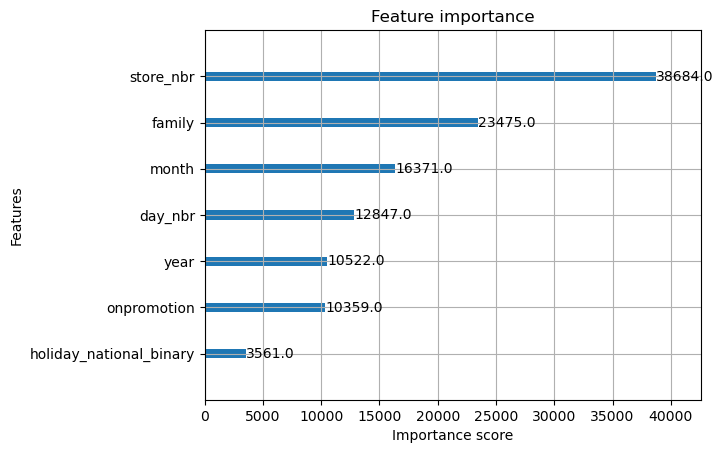

In [130]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(reg, max_num_features=20)
plt.show()


In [133]:
r2_score(y_val, y_pred)

0.9693139791488647

In [145]:
# base_score=0.5, booster='gbtree', 
#                         enable_categorical=True,  
#                         n_estimators=1000,
#                         early_stopping_rounds=50,
#                         objective='reg:linear',
#                         max_depth=7,
#                         learning_rate=0.05,
#Αυτα ειχαν 201 RMSE

param_grid = {
    'max_depth': [8],
    'learning_rate': [0.1],
    'n_estimators': [1000],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 1],
}

In [146]:
from sklearn.model_selection import ParameterGrid

for params in ParameterGrid(param_grid):
    model = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        enable_categorical=True,
        objective='reg:linear',
        early_stopping_rounds=50,
        **params
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=0
    )

    preds = model.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, preds))
    print(f"Params: {params} --> RMSE: {score:.4f}")


Params: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.8} --> RMSE: 204.4888
Params: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 1.0} --> RMSE: 202.4258
Params: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 1000, 'subsample': 0.8} --> RMSE: 201.1577
Params: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 1000, 'subsample': 1.0} --> RMSE: 203.1891
Params: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 1000, 'subsample': 0.8} --> RMSE: 200.4836
Params: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 1000, 'subsample': 1.0} --> RMSE: 202.2735
Pa

KeyboardInterrupt: 

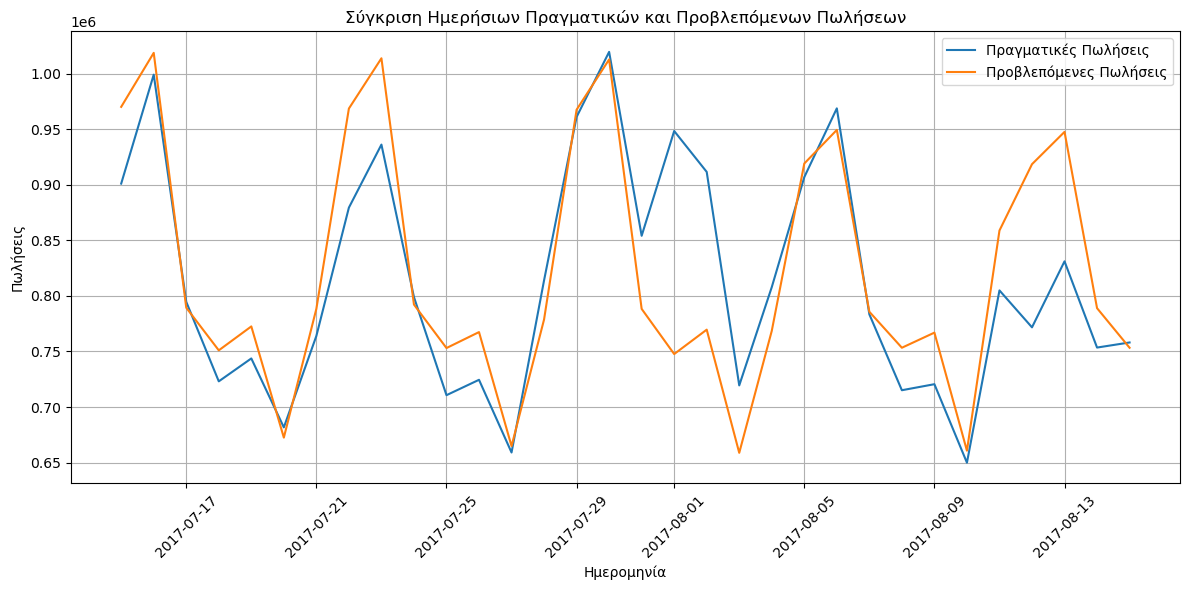

In [ ]:
daily_summary = df_plot.groupby('date')[['actual', 'predicted']].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(daily_summary['date'], daily_summary['actual'], label='Πραγματικές Πωλήσεις')
plt.plot(daily_summary['date'], daily_summary['predicted'], label='Προβλεπόμενες Πωλήσεις')
plt.xlabel('Ημερομηνία')
plt.ylabel('Πωλήσεις')
plt.title('Σύγκριση Ημερήσιων Πραγματικών και Προβλεπόμενων Πωλήσεων')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
X_val.info()

In [ ]:
#NHITS

# Θελω για αρχη να τρεξω το μοντελο μονο με τις static μεταβλητες
df = df.drop([ 'id','onpromotion', 'city','state', 'type', 'cluster', 'dcoilwtico', 'transactions', 'day','holiday_national', 'holiday_regional', 'holiday_local', 'event',
       'holiday_national_binary', 'holiday_regional_binary',
       'holiday_local_binary',],axis=1)
df['unique_id'] = df['store_nbr'].astype(str) + '_' + df['family']
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['sales']

In [ ]:
logging.getLogger("pytorch_lightning").setLevel(logging.INFO)

In [ ]:
duplicates = df.groupby(['unique_id', 'ds']).size().reset_index(name='count')
duplicates = duplicates[duplicates['count'] > 1]

if duplicates.empty:
    print("✅ Κάθε unique_id εμφανίζεται το πολύ μία φορά ανά ημερομηνία.")
else:
    print("❌ Υπάρχουν διπλότυπα:")
    display(duplicates.head())

df_agg = df.groupby(['unique_id', 'ds'], as_index=False)['y'].sum()
df = df_agg

# Split into train and future (NHITS uses sliding windows, not test sets in the usual sense)
df_train = df.groupby('unique_id').apply(lambda x: x.iloc[:-30]).reset_index(drop=True)
df_test = df.groupby('unique_id').apply(lambda x: x.iloc[-30:]).reset_index(drop=True)


model = NeuralForecast(
    models=[NHITS(input_size=90, h=30, max_steps=2000, scaler_type='standard', loss=RMSE(),learning_rate=5e-5)],
    freq='D',
)

# model = NeuralForecast(models=[NHITS(input_size=2*H, h=H)], freq='D')
# Fit the model
model.fit(df_train)

In [ ]:
# Predict
df_forecast = model.predict()

# Rename 'y' to 'y_actual' in df_test to match expected column name after merge
df_test_renamed = df_test.rename(columns={'y': 'y_actual'})

In [ ]:
# Merge forecasts and actuals
df_eval = pd.merge(
    df_forecast, 
    df_test_renamed, 
    on=['unique_id', 'ds'], 
    how='left'
)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_squared_log_error
import numpy as np
# Calculate metrics
mae = mean_absolute_error(df_eval['y_actual'], df_eval['NHITS'])
rmse = np.sqrt(mean_squared_error(df_eval['y_actual'], df_eval['NHITS']))
#rmsle = np.sqrt(mean_squared_log_error(df_eval['y_actual'], df_eval['NHITS']))
print(f"MAE:  {mae:.2f}")
print(f"RMSE:  {rmse:.2f}")
#print(f"RMSLE:  {rmsle:.2f}")

In [ ]:
df_forecast= df_forecast.reset_index()

In [ ]:
plot_series(df,df_forecast, max_insample_length=24*5)

In [ ]:
plot_series(df[df['unique_id'].isin(['10_AUTOMOTIVE', '2_BEVERAGES'])])

In [ ]:
# # Ensure both components are strings
# df['store_nbr'] = df['store_nbr'].astype(str)
# df['family'] = df['family'].astype(str)

# # Create the unique_id column
# df['unique_id'] = df['store_nbr'] + '_' + df['family']

In [ ]:
# df = df.rename(columns={'date': 'ds'})
# df_forecast = df[['ds', 'sales', 'unique_id']].rename(columns={'sales': 'y'})
# df_forecast = df_forecast.set_index('unique_id')

In [ ]:
# df_2017 = df_forecast[df_forecast['ds'].dt.year == 2017]

In [ ]:
# df_2017 = df_2017.reset_index()
# df_2017.head()


In [ ]:
# df_2017.to_csv(r"/mnt/c/Users/aimeraj/Desktop/data2/df_2017.csv",index=False)

In [ ]:
# static_df = static_df.set_index('unique_id')
# static_df =static_df.drop('Unnamed: 0',axis=1)

In [ ]:
# config_nhits = {
#     "input_size": tune.choice([48, 96, 144]),            
#     "start_padding_enabled": True,
#     "n_blocks": [1, 1, 1, 1, 1],                         
#     "mlp_units": [[64, 64]] * 5,                         
#     "n_pool_kernel_size": tune.choice([
#         [1, 1, 1, 1, 1],
#         [2, 2, 2, 2, 2],
#         [4, 4, 4, 4, 4],
#         [8, 4, 2, 1, 1]
#     ]),
#     "n_freq_downsample": tune.choice([
#         [8, 4, 2, 1, 1],
#         [1, 1, 1, 1, 1]
#     ]),
#     "learning_rate": tune.loguniform(1e-4, 1e-2),
#     "scaler_type": None,
#     "max_steps": 1000,
#     "batch_size": tune.choice([1, 4, 10]),
#     "windows_batch_size": tune.choice([128]),
#     "random_seed": tune.randint(1, 21),                   
#}

In [ ]:
# horizon = 15
# model = [
#     NHITS(
#         h=horizon,
#         input_size= 10 * horizon,        # Use 75 past days (tune this!)
#         max_steps=100,                   # Total training steps (tune based on dataset size)
#         stat_exog_list=static_df.columns.tolist(),  # List of static variable names
#         scaler_type='robust',            # Robust scaling handles outliers better
#         loss=MQLoss(),                   # Quantile loss (good for uncertainty)
#         n_blocks=[1, 1, 1],              # Simplify if training is slow
#     )
# ]

In [ ]:
### Διαφορα πραγματα που ειχα γραψει προσπαθωντας να τρεξω NHITS 
### Τα εκανα comment out επειδη δεν ειναι με σειρα ωστε να δουλευουν

# df_2017.head()
# df_2017 = df_2017.loc["1_AUTOMOTIVE"]
# static_df = static_df[['1_AUTOMOTIVE']]
# nf = NeuralForecast(models=model, freq='D')
# nf.fit(df=df_2017, static_df=static_df)
# Y_hat_df = nf.predict()
# # Όταν κάνεις reset_index, βάλε το σωστό όνομα:
# df_2017_reset = df_2017.reset_index().rename(columns={'index': 'unique_id'})
# df_2017 = df_2017.reset_index()
# # Βήμα 1: Reset το df σου
# df_2017_reset = df_2017.reset_index()

# # Βήμα 2: Reset και το forecast
# Y_hat_df = Y_hat_df.reset_index()

# # Βήμα 3: Τσέκαρε τι στήλες έχουν
# print(df_2017_reset.columns)
# print(Y_hat_df.columns)

# # Βήμα 4: Plot
# plot_series(df_2017_reset, Y_hat_df, max_insample_length=24*5)

# df_2017_reset = df_2017.reset_index()  # φέρνει το unique_id ως στήλη
# assert set(df_2017.index.unique()) <= set(static_df.index), "Mismatch in unique_ids!"

# missing_ids = set(df_2017.index.unique()) - set(static_df.index)
# print(missing_ids)

# for missing_id in missing_ids:
#     static_df.loc[missing_id] = [0] * static_df.shape[1]  # ή βάλε default τιμές

# nf = NeuralForecast(models=model, freq='D')  # Daily frequency
# nf.fit(df= df_2017, static_df=static_df)

# df_forecast.head()
# df_2017 = df_forecast[df_forecast['ds'].dt.year == 2017]
# del df_forecast

# nf = NeuralForecast(models=model, freq='D')
#nf.fit(df=df_2017, static_df=static_df)